---
# **A Deep-Learning-Based Alpha Factor Identification**
---

- Author: Kaichong Wang (kw3181@nyu.edu)
- Date: March 18, 2023

The project is reviewed and updated in March, 2024.

**💻 OVERVIEW**

- The factor is identified and computed using an LSTM deep neural network. The network receives input from a stock's profile, which comprises a recent trend relative to the market. This profile is made up of a $1\times10\times7$ three-dimensional tensor. The tensor contains time-series data of seven features: standardized (relative) volume, amount, turnover, open price change, high price change, low price change, and close price change, over the most recent 10 transaction days (2 weeks). The output is a predicted value of the stock's standardized excess return. This method closely resembles the work of technical analysts, which examines a stock's recent price trend to predict future performance.
- The network was trained using the market data of all tickers (about 5000 in total) in the Chinese A-share market from November 1, 2021, to March 1, 2022. It was trained to predict their daily forward return based on their profiles. The score output by the trained network is used as the alpha factor with daily frequency.
- I tested the factor's explainability to return and its stability from March 1, 2022, to May 1, 2022. The factor is quite effective with an **average information coefficient of 0.07**, an **information ratio of 0.91**, good monotonicity in stock selection, and **annualized Sharpe ratios of 2.66 for a long portfolio** (14.48 for a long-short portfolio).

## 1. Set-ups and Data Loading

In [ ]:
%%capture

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from google.colab import drive

In [ ]:
%%capture
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Internship/data_prj2'

In [ ]:
# Load the data
# open = pd.read_hdf("open.hdf", key='data')
#close = pd.read_hdf("close.hdf", key='data')
#high = pd.read_hdf("high.hdf", key='data')
#low = pd.read_hdf("low.hdf", key='data')
#vol = pd.read_hdf("vol.hdf", key='data')
#turn = pd.read_hdf("turn.hdf", key='data')
#amount = pd.read_hdf("amount.hdf", key='data')

# Melt the data
#open = pd.melt(open.reset_index(), id_vars='date', var_name='Ticker', value_name='Open').rename(columns={'date':'Date'})
#close = pd.melt(close.reset_index(), id_vars='date', var_name='Ticker', value_name='Close').rename(columns={'date':'Date'})
#high = pd.melt(high.reset_index(), id_vars='date', var_name='Ticker', value_name='High').rename(columns={'date':'Date'})
#low = pd.melt(low.reset_index(), id_vars='date', var_name='Ticker', value_name='Low').rename(columns={'date':'Date'})
#vol = pd.melt(vol.reset_index(), id_vars='index', var_name='Ticker', value_name='Vol').rename(columns={'index':'Date'})
#turn = pd.melt(turn.reset_index(), id_vars='date', var_name='Ticker', value_name='Turn').rename(columns={'date':'Date'})
#amount = pd.melt(amount.reset_index(), id_vars='index', var_name='Ticker', value_name='Amount').rename(columns={'index':'Date'})

# Merge the data
#df = pd.merge(open, close, on=['Date', 'Ticker'], how='left')
#df = pd.merge(df, high, on=['Date', 'Ticker'], how='left')
#df = pd.merge(df, low, on=['Date', 'Ticker'], how='left')
#df = pd.merge(df, vol, on=['Date', 'Ticker'], how='left')
#df = pd.merge(df, turn, on=['Date', 'Ticker'], how='left')
#df = pd.merge(df, amount, on=['Date', 'Ticker'], how='left')

In [ ]:
# Let's use the percentage change of close price as return
# df['Today Ret'] = df.groupby('Ticker')['Close'].pct_change()
# df['Tomorrow Ret'] = df.groupby('Ticker')['Today Ret'].shift(-1)

# Drop the instances that have invalid targets
# df = df.dropna(subset=['Tomorrow Ret'], axis=0)
# df = df[np.isfinite(df['Tomorrow Ret'])]

# df.to_csv('df.csv', index=False)

In [ ]:
# df = pd.read_csv("df.csv")

For Prices, we calculte their relative change to last-day close price. The Price Changes are calculated as follows:

$$
\%\Delta O_{t, i} = \frac{O_{t, i}}{C_{t-1, i}} - 1,~
\%\Delta H_{t, i} = \frac{H_{t, i}}{C_{t-1, i}} - 1,~
\%\Delta L_{t, i} = \frac{L_{t, i}}{C_{t-1, i}} - 1,~
\%\Delta C_{t, i} = \frac{C_{t, i}}{C_{t-1, i}} - 1
$$

for ticker $i$ on date $t$.

In [ ]:
# # For OHLC, we calculte their relative change to last-day close price.

# df['Open Change'] = df['Open'] / df.groupby('Ticker')['Close'].shift(1) - 1
# df['High Change'] = df['High'] / df.groupby('Ticker')['Close'].shift(1) - 1
# df['Low Change'] = df['Low'] / df.groupby('Ticker')['Close'].shift(1) - 1
# df['Close Change'] = df['Close'] / df.groupby('Ticker')['Close'].shift(1) - 1
# df = df.drop(columns=['Today Ret'])

# # Remove the first month
# df = df[(df['Date'] >= '2013-02-01')]

In [ ]:
# df['Date'] = pd.to_datetime(df['Date'])

# # Select Data Range
# start_date = '2018-01-01'
# end_date = '2023-07-01'

# df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

In [ ]:
# features_list = ['Vol', 'Turn', 'Amount', 'Open Change', 'High Change', 'Low Change', 'Close Change']

In [ ]:
def winsorize_field(column, method=2, u=0.99, l=0.01, z=5):
    if method == 1:
        upper_bound = column.quantile(u)
        lower_bound = column.quantile(l)
    if method == 2:
        median_value = column.median()
        mad_value = np.median(np.abs(column - median_value))
        upper_bound = median_value + z * mad_value
        lower_bound = median_value - z * mad_value
    column = column.clip(lower_bound, upper_bound)
    return column

# for field_column in features_list:
#     df[field_column] = df.groupby('Date')[field_column].transform(winsorize_field)

# df['Tomorrow Ret (Scaled)'] = df.groupby('Date')['Tomorrow Ret'].transform(winsorize_field)

In [ ]:
# # Standardization
# features_list.append('Tomorrow Ret (Scaled)')

# for field_column in features_list:
#     df[field_column + ' (Standardized)'] = (df[field_column] - df.groupby('Date')[field_column].transform('mean')) / df.groupby('Date')[field_column].transform('std')

# # Invalid Values Imputation
# for field_column in features_list:
#     df[field_column + ' (Standardized)'].fillna(0.0, inplace=True)
#     df[field_column + ' (Standardized)'].replace([np.inf, -np.inf], 0.0, inplace=True)

In [ ]:
# df.head()
# # df.to_hdf('df_preprocessed.h5', key='data', mode='w')

In [ ]:
# # Training Set: from 2021-05-01 to 2022-05-01
# # Testing Set: from 2022-05-15 to 2022-12-31

# df_train = df[(df['Date'] >= '2021-05-01') & (df['Date'] <= '2022-05-01')].reset_index(drop=True)
# df_test = df[(df['Date'] >= '2022-05-15') & (df['Date'] <= '2022-12-31')].reset_index(drop=True)

# # There is a very weird bug: df_test contains one inf
# df_test = df_test[np.isfinite(df_test['Tomorrow Ret'])]

In [ ]:
# df_train.to_hdf('df_train.h5', key='data', mode='w')
# df_test.to_hdf('df_test.h5', key='data', mode='w')

In [ ]:
# # df_train.to_hdf('df_train.h5', key='data', mode='w')
# # df_test.to_hdf('df_test.h5', key='data', mode='w')

df_train = pd.read_hdf('df_train.h5', key='data')
df_test = pd.read_hdf('df_test.h5', key='data')

## 2. DL-Based Technical Alpha Factor Identification

🤖 **Deep Learning Based Factor Identification**

Identifying alpha factors using deep learning involves the following approach: We utilize a Long Short-Term Memory (LSTM) network, feeding it three-dimensional temporal data consisting of *seven* sequential variables with length **ten** (nearest two weeks)—
- Volume (`Vol`),
- Turnover (`Turn`),
- Amount (`Amount`),
- Open Price Change (`Open Price Change`),
- High Price Change (`High Change`),
- Low Price Change (`Low Change`), and
- Close Price Change (`Close Change`)

—for all tickers in the Chinese A-share market over a recent 10-day period.

These variables are standardized at each time step across the cross-section of all tickers, so that each input row represent the ticker's price & volumes trend relative to the market. This setting aims to encapsulate price & volumes trends' critical information as perceived by a technical analyst.

The LSTM network is trained to predict the next day's standardized returns, which represent relative market performance, by minimizing the Mean Squared Error (MSE) loss against actual outcomes. Through this training process, the network learns to discern the implications of a ticker's price & volumes trend on its future relative performance.

Once trained, this deep learning model can evaluate a ticker's market data to output a forecast of its anticipated relative performance. The output serves as our Deep Learning-Based Technical Alpha Factor.

In [ ]:
# Training Set: from 2021-11-01 to 2022-03-01
# Validation Set: from 2022-03-01 to 2022-05-01

data_train, data_valid = df_train[df_train['Date'] < '2022-03-01'], df_train[df_train['Date'] >= '2022-03-01']

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torch.nn.init as init
from torch.utils.data import random_split
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
target_name = 'Tomorrow Ret (Scaled) (Standardized)'

def df_to_tensor(data, dtype=torch.float32):
    return torch.tensor(np.array(data), dtype=dtype).to(device)

class RNNDataset(torch.utils.data.Dataset):
    def __init__(self, data, selected_features, seq_n):
        data.index = [data['Date'], data['Ticker']]
        data = data.drop(['Date', 'Ticker'], axis=1)
        df = data.swaplevel().sort_index().copy()
        sample_index = df.groupby('Ticker')[selected_features].shift(seq_n-1).dropna().index.tolist()
        inputs = df.loc[:, selected_features]
        labels = df[[target_name]]

        self.data_list = []
        for sample in tqdm(sample_index, 'loading', leave=False):
            data_tuple = (
                df_to_tensor(inputs.loc[:sample].iloc[-seq_n:]),
                df_to_tensor(labels.loc[sample])
            )
            self.data_list.append(data_tuple)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        return output


def initialize_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            init.xavier_uniform_(param)


def train(model, batch_size, train_dataset, valid_dataset, num_epochs, learning_rate, early_stop=True, patience=5, verbose=False, evaluation=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    if evaluation:
        dataloader_valid = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    current_patience = 0

    initialize_weights(model)  # Reset model weights before training

    for epoch in range(num_epochs):
        model.train()
        train_losses_batch, valid_losses_batch = [], []

        # Training phase
        for inputs, targets in tqdm(dataloader, total=len(dataloader), desc='Training', leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.view_as(outputs)
            loss = criterion(outputs, targets)
            train_losses_batch.append(loss.item())
            loss.backward()
            optimizer.step()

        average_train_loss = sum(train_losses_batch) / len(train_losses_batch)
        train_losses.append(average_train_loss)

        if verbose:
            print(f"Epoch [{epoch + 1}/{num_epochs}]: \tTraining Loss: {average_train_loss:.4f}", end="")

        if not evaluation:
            if verbose:
                print()  # Newline for better formatting
            continue

        # Validation phase
        model.eval()
        with torch.no_grad():
            for inputs, targets in dataloader_valid:
                outputs = model(inputs)
                targets = targets.view_as(outputs)
                loss = criterion(outputs, targets)
                valid_losses_batch.append(loss.item())
            average_valid_loss = sum(valid_losses_batch) / len(valid_losses_batch)
            valid_losses.append(average_valid_loss)

        if verbose:
            print(f", Validation Loss: {average_valid_loss:.4f}")

        if early_stop:
            if average_valid_loss < best_valid_loss:
                best_valid_loss = average_valid_loss
                current_patience = 0
            else:
                current_patience += 1

            if current_patience >= patience:
                print("\nEarly stopping triggered. No improvement in validation loss for {} consecutive epochs.".format(patience))
                break

    if verbose and evaluation:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(valid_losses, label='Validation Loss')
        plt.title("Training and Validation Losses Over Epochs")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

**🪧 NOTE**

After reviewing the project eight months later, I've identified several critical issues:

1. The neural network architecture lacks depth, as it does not incorporate any activation functions, resulting in a linear model.
2. The model's performance could potentially be enhanced by training it exclusively on a curated selection of tickers, specifically those included in the market index.

```
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        return output
```
I will fix the first issue.


In [ ]:
seq_n = 10

selected_features = ['Open Change (Standardized)',
                     'High Change (Standardized)',
                     'Low Change (Standardized)',
                     'Close Change (Standardized)',
                     'Vol (Standardized)',
                     'Turn (Standardized)',
                     'Amount (Standardized)']

# train_dataset = RNNDataset(data_train, selected_features=selected_features, seq_n=seq_n) # 10 minutes
# valid_dataset = RNNDataset(data_valid, selected_features=selected_features, seq_n=seq_n) # 3 minutes

In [ ]:
# Training (It will take about 90 minutes)

input_size = len(selected_features)
# model = LSTMModel(input_size=input_size, dropout_prob=0.2).to(device)
# train(model, batch_size=64, train_dataset=train_dataset, valid_dataset=valid_dataset, num_epochs=10, learning_rate=1e-4, early_stop=False, patience=5, verbose=True)

Let's try a deeper model.



```
class DeepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size_1=128, hidden_size_2=32, output_size=1, dropout_prob=0.2, num_layers=2):
        super(DeepLSTMModel, self).__init__()
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2

        # Updated LSTM to have multiple layers and dropout
        self.lstm = nn.LSTM(input_size, hidden_size_1, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        
        # Additional fully connected layer
        self.fc1 = nn.Linear(hidden_size_1, hidden_size_2)  # Intermediate layer
        self.fc2 = nn.Linear(hidden_size_2, output_size)  # Output layer
        
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()  # Non-linearity

    def forward(self, x):
        # Passing in the input and hidden state into the model and obtaining outputs
        _, (hidden, _) = self.lstm(x)
        
        # Considering the last layer's hidden state
        hidden = self.dropout(hidden[-1,:,:])  # Apply dropout to the last layer's output
        
        # Adding non-linear activation function between layers
        hidden = self.relu(self.fc1(hidden))
        hidden = self.dropout(hidden)  # Apply dropout
        
        output = self.fc2(hidden)
        return output
```





In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        return output

In [ ]:
class DeepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size_1=128, hidden_size_2=32, output_size=1, dropout_prob=0.2, num_layers=2):
        super(DeepLSTMModel, self).__init__()
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2

        # Updated LSTM to have multiple layers and dropout
        self.lstm = nn.LSTM(input_size, hidden_size_1, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        # Additional fully connected layer
        self.fc1 = nn.Linear(hidden_size_1, hidden_size_2)  # Intermediate layer
        self.fc2 = nn.Linear(hidden_size_2, output_size)  # Output layer

        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()  # Non-linearity

    def forward(self, x):
        # Passing in the input and hidden state into the model and obtaining outputs
        _, (hidden, _) = self.lstm(x)

        # Considering the last layer's hidden state
        hidden = self.dropout(hidden[-1,:,:])  # Apply dropout to the last layer's output

        # Adding non-linear activation function between layers
        hidden = self.relu(self.fc1(hidden))
        hidden = self.dropout(hidden)  # Apply dropout

        output = self.fc2(hidden)
        return output

In [ ]:
model_2 = DeepLSTMModel(input_size=input_size, dropout_prob=0.2).to(device)
train(model_2, batch_size=64, train_dataset=train_dataset, valid_dataset=valid_dataset, num_epochs=30, learning_rate=5e-5, early_stop=False, patience=5, verbose=True)

NameError: name 'DeepLSTMModel' is not defined

In [ ]:
# Retrain the model with full set of data, num_epochs = 5 (about 5 minutes)
best_num_epochs = 5
dataset = RNNDataset(df_train, selected_features=selected_features, seq_n=seq_n)

model = DeepLSTMModel(input_size=input_size, dropout_prob=0.2).to(device)
train(model,
      batch_size=64,
      train_dataset=dataset,
      valid_dataset=None,
      num_epochs=best_num_epochs,
      learning_rate=1e-4,
      verbose=True,
      evaluation=False) # 5 minutes


# Save the model state
model_path = 'model_2.pth'
print()
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Epoch [1/11]: 	Training Loss: 0.9848


Epoch [2/11]: 	Training Loss: 0.9809


Epoch [3/11]: 	Training Loss: 0.9792


Epoch [4/11]: 	Training Loss: 0.9780


Epoch [5/11]: 	Training Loss: 0.9772


Epoch [6/11]: 	Training Loss: 0.9763


Epoch [7/11]: 	Training Loss: 0.9756


Epoch [8/11]: 	Training Loss: 0.9747


Epoch [9/11]: 	Training Loss: 0.9741


Epoch [10/11]: 	Training Loss: 0.9733


Epoch [11/11]: 	Training Loss: 0.9727

Model saved to model_2.pth


In [ ]:
# Load the model
model = DeepLSTMModel(input_size=input_size, dropout_prob=0.2).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
# Prepare the Dataset (Train)
train_dates_list = df_train['Date'].unique()
df_t = df_train.copy()
df_t.index = [df_t['Date'], df_t['Ticker']]
df_t = df_t.drop(['Date', 'Ticker'], axis=1)
df_t = df_t.swaplevel().sort_index()
sample_index = df_t.groupby('Ticker').shift(seq_n-1).dropna().index.tolist()
inputs = df_t.loc[:, selected_features]
data_list = []
for sample in tqdm(sample_index, 'loading', leave=False):
    data_list.append(df_to_tensor(inputs.loc[:sample].iloc[-seq_n:]))

In [ ]:
# Predict Absolute Return
y_train_pred = []
for X_i in tqdm(data_list, 'Predicting', leave=False):
    with torch.no_grad():
        # y_i = model(X_i).detach().numpy().reshape(-1)
        y_i = model(X_i.unsqueeze(0)).detach().cpu().numpy().reshape(-1)
    y_train_pred.extend(y_i)
df_t.loc[sample_index, 'Predicted Ret (Scaled)'] = np.array(y_train_pred)
df_t = df_t.swaplevel().sort_index()
df_t.reset_index(level=1, drop=False, inplace=True)
df_t.reset_index(inplace=True)


# Record Prediction: the Alpha Factor
data_train_dl_2 = df_t.copy()[['Date', 'Ticker', 'Tomorrow Ret', 'Tomorrow Ret (Scaled) (Standardized)']]
data_train_dl_2['Predicted Ret (Scaled)'] = np.nan
data_train_dl_2['Predicted Ret (Scaled)'] = df_t['Predicted Ret (Scaled)']
data_train_dl_2 = data_train_dl_2.dropna(subset=['Predicted Ret (Scaled)']).reset_index(drop=True)

In [ ]:
# Prepare the Dataset (Test)
test_dates_list = df_test['Date'].unique()
df_t = df_test.copy()
df_t.index = [df_t['Date'], df_t['Ticker']]
df_t = df_t.drop(['Date', 'Ticker'], axis=1)
df_t = df_t.swaplevel().sort_index()
sample_index = df_t.groupby('Ticker').shift(seq_n-1).dropna().index.tolist()
inputs = df_t.loc[:, selected_features]
data_list = []
for sample in tqdm(sample_index, 'loading', leave=False):
    data_list.append(df_to_tensor(inputs.loc[:sample].iloc[-seq_n:]))

In [ ]:
# Predict Absolute Return
y_test_pred = []
for X_i in tqdm(data_list, 'Predicting', leave=False):
    with torch.no_grad():
        # y_i = model(X_i).detach().numpy().reshape(-1)
        y_i = model(X_i.unsqueeze(0)).detach().cpu().numpy().reshape(-1)
    y_test_pred.extend(y_i)
df_t.loc[sample_index, 'Predicted Ret (Scaled)'] = np.array(y_test_pred)
df_t = df_t.swaplevel().sort_index()
df_t.reset_index(level=1, drop=False, inplace=True)
df_t.reset_index(inplace=True)


# Record Prediction: the Alpha Factor
data_test_dl_2 = df_t.copy()[['Date', 'Ticker', 'Tomorrow Ret', 'Tomorrow Ret (Scaled) (Standardized)']]
data_test_dl_2['Predicted Ret (Scaled)'] = np.nan
data_test_dl_2['Predicted Ret (Scaled)'] = df_t['Predicted Ret (Scaled)']
data_test_dl_2 = data_test_dl_2.dropna(subset=['Predicted Ret (Scaled)']).reset_index(drop=True)

In [ ]:
data_train_dl_2.head()

,Date,Ticker,Tomorrow Ret,Tomorrow Ret (Scaled) (Standardized),Predicted Ret (Scaled)
0,2021-05-19,000001.SZ,0.009322,0.578286,0.056214
1,2021-05-19,000002.SZ,0.007471,0.498706,0.018649
2,2021-05-19,000004.SZ,-0.003303,0.035518,-0.027932
3,2021-05-19,000005.SZ,-0.049451,-1.948529,0.111366
4,2021-05-19,000006.SZ,-0.013060,-0.383974,0.038801


In [ ]:
data_test_dl_2.head()

,Date,Ticker,Tomorrow Ret,Tomorrow Ret (Scaled) (Standardized),Predicted Ret (Scaled)
0,2022-05-27,000001.SZ,-0.007052,-0.688607,0.019554
1,2022-05-27,000002.SZ,-0.017641,-1.167042,0.010873
2,2022-05-27,000004.SZ,0.019108,0.493450,0.010525
3,2022-05-27,000005.SZ,0.000000,-0.369955,0.045087
4,2022-05-27,000006.SZ,-0.004566,-0.576279,-0.028082


In [ ]:
data_train_dl_2.to_hdf('data_train_dl_2.h5', key='data', mode='w')
data_test_dl_2.to_hdf('data_test_dl_2.h5', key='data', mode='w')

Let's quickly check the model's performance.

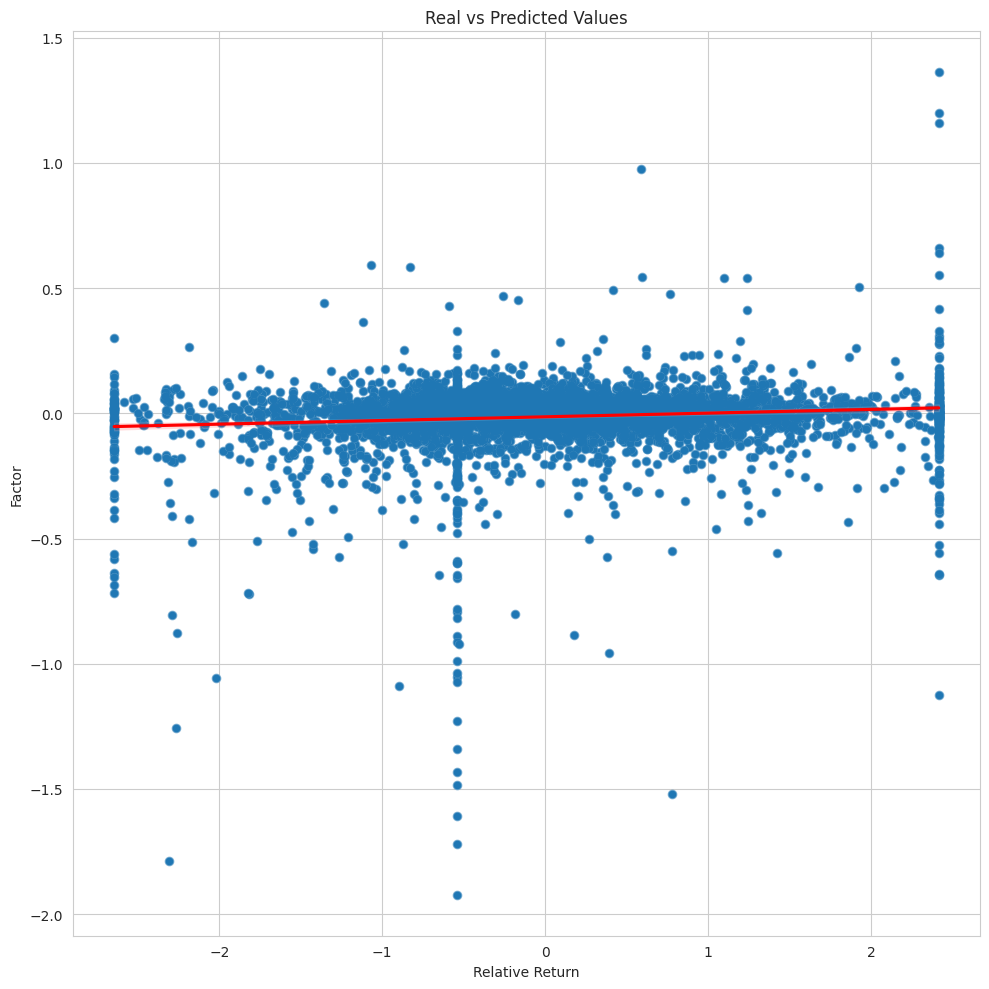

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
sns.scatterplot(x='Tomorrow Ret (Scaled) (Standardized)', y='Predicted Ret (Scaled)', data=data_train_dl_2[data_train_dl_2['Date'] == '2022-04-29'])
sns.regplot(x='Tomorrow Ret (Scaled) (Standardized)', y='Predicted Ret (Scaled)', data=data_train_dl_2[data_train_dl_2['Date'] == '2022-04-29'],
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Real vs Predicted Values')
plt.xlabel('Relative Return')
plt.ylabel('Factor')
plt.tight_layout()

plt.show()

## 3. Factor Testing

I follow the alpha factor testing framework [2].

> **⚠️ IMPORTANT**: Testing Period: 2022-05-15 to 2022-12-31

In [ ]:
# Load the factor data
data_test_dl = pd.read_hdf('data_test_dl_2.h5', key='data')
backtest_date = data_test_dl['Date'].unique()

# Preprocessing
data_test_dl['DL Factor (Standardized)'] = data_test_dl.groupby('Date')['Predicted Ret (Scaled)'].transform(winsorize_field) # Winsorization
data_test_dl['DL Factor (Standardized)'] = (data_test_dl['DL Factor (Standardized)'] - data_test_dl.groupby('Date')['DL Factor (Standardized)'].transform('mean')) / data_test_dl.groupby('Date')['DL Factor (Standardized)'].transform('std') # Standardization
data_test_dl['DL Factor (Standardized)'].fillna(0.0, inplace=True)
data_test_dl['DL Factor (Standardized)'].replace([np.inf, -np.inf], 0.0, inplace=True)
data_test_dl = data_test_dl.drop(columns=['Predicted Ret (Scaled)'])

# Merge Industry and MktCap data
df_ind = pd.read_csv('industry.csv', encoding='GBK').rename(columns={'代码': 'Ticker', '长江二级行业': 'Industry', '日期': 'Date'})
df_ind['Date'] = pd.to_datetime(df_ind['Date'])
df_ind = df_ind[df_ind['Date'] == backtest_date[-1]]
df_ind = df_ind[df_ind['Ticker'].isin(data_test_dl['Ticker'].unique())]
df_ind.index = df_ind['Ticker']
ind_map = df_ind['Industry'].to_dict()
data_test_dl['Industry'] = data_test_dl['Ticker'].map(ind_map)

df_mktcap = pd.read_csv('market_cap.csv').rename(columns={'DATETIME': 'Date'})
df_mktcap['Date'] = pd.to_datetime(df_mktcap['Date'])
df_mktcap = df_mktcap[df_mktcap['Date'].isin(backtest_date)]
df_mktcap = pd.melt(df_mktcap.reset_index(drop=True), id_vars='Date', var_name='Ticker', value_name='MktCap')
data_test_dl = pd.merge(data_test_dl, df_mktcap, on=['Date', 'Ticker'], how='left')
data_test_dl = data_test_dl.dropna()

del df_ind
del df_mktcap

data_test_dl.head()

,Date,Ticker,Tomorrow Ret,Tomorrow Ret (Scaled) (Standardized),DL Factor (Standardized),Industry,MktCap
0,2022-05-27,000001.SZ,-0.007052,-0.688607,0.229830,002094.CJ,2.751759e+11
1,2022-05-27,000002.SZ,-0.017641,-1.167042,0.093312,002118.CJ,2.108845e+11
2,2022-05-27,000004.SZ,0.019108,0.493450,0.087833,002112.CJ,1.469549e+09
3,2022-05-27,000005.SZ,0.000000,-0.369955,0.631381,002059.CJ,1.968879e+09
4,2022-05-27,000006.SZ,-0.004566,-0.576279,-0.519335,002118.CJ,5.912978e+09


The `DL Factor (Standardized)` refers to the preprocessed factor loading.

**🪧 NOTE**
- Tests are conducted using all tickers in the A-share market as a sample. However, choosing a smaller sample, such as tickers in ZZ800, could be more effective.
- The `Industry` is based on data provided by Changjiang Securities. As of December 31, 2022, it classifies most stocks in the A-share market into 200 industries. Stocks from unclassified industries have been excluded.

These aspects are left for future work.

### 1. Statistical Testing

- IC, RankIC
- t-value

---
**🧮 METHODOLOGY**

For each time point $ t $ in our backtesting period, we define:

- $ \mathbf{f}_t $ as the cross-sectional data of factor exposure, specifically the standardized values of the Deep Learning (DL) factor for all securities at time $ t $.
- $ \mathbf{r}_t $ as the absolute return of the cross-sectional data at time $ t $, calculated as $ \mathbf{r}_t = \frac{\mathbf{C}_{t+1}}{\mathbf{C}_t} - 1 $, representing the percentage change in close price from time $ t $ to $ t+1 $. The operator "/" denotes element-wise division.
- $ \mathbf{f}_{\text{MktCap}, t} $ for market capitalization data of the securities at time $ t $.
- $ \mathbf{f}_{\text{ind}, t}^{i} $ for the one-hot encoded industry data of the securities, where each $ \beta_{\text{ind}, t}^{i} $ represents the coefficient for industry $ i $ at time $ t $.

The regression model used to predict the returns $ \mathbf{r}_t $ based on these factors is given by the equation:

$$
\mathbf{r}_t = \beta_{0, t} + \beta_{\text{factor}, t} \mathbf{f}_t + \beta_{\text{MktCap}, t} \mathbf{f}_{\text{MktCap},t} + \sum \beta_{\text{ind}, t}^{i} \mathbf{f}_{\text{ind}, t}^{i} + \mathbf{\epsilon}_t
$$

where $ \mathbf{\epsilon}_t $ represents the error term.

The **Information Coefficient (IC)** and **Rank Information Coefficient (RankIC)** are calculated as follows:

- The **IC** at time $ t $ is determined by the Pearson correlation coefficient between the factor exposures $ \mathbf{f}_t $ and the returns $ \mathbf{r}_t $, measuring the linear relationship between the factor values and the actual returns.
- The **RankIC** is calculated using the Spearman rank correlation coefficient between the same sets of data, $ \mathbf{f}_t $ and $ \mathbf{r}_t $, assessing the monotonic relationship regardless of the specific linear form.
- For each time period, the **t-value** associated with the factor $ \mathbf{f}_t $ in the regression model quantifies the statistical significance of the factor's coefficient $ \beta_{\text{factor}, t} $, determined within the context of the broader model that includes market capitalization and industry effects. The t-value is calculated from the regression analysis, indicating how many standard deviations the estimated coefficient is away from 0, under the assumption that the null hypothesis (the coefficient is zero) is true.

---
**📈 RESULTS**

The analysis of the alpha factor across all tickers in the A-share market, based on their factor exposure against next-day absolute return over the Testing Period - 2022-05-15 to 2022-12-31, yielded the following statistics:

| Metric                               | Value   |
|--------------------------------------|---------|
| Mean IC                              | 0.0737  |
| IC std                               | 0.0808  |
| ICIR                                 | 0.9126  |
| Proportion that IC > 0               | 81.21%  |
| Proportion that \|IC\| > 0.02        | 85.91%  |
| Mean RankIC                          | 0.0863  |
| RankIC std                           | 0.1047  |
| RankICIR                             | 0.8241  |
| Proportion that RankIC > 0           | 78.52%  |
| Proportion that \|RankIC\| > 0.02    | 89.26%  |
| \|t-value\| mean                     | 5.8454  |
| Proportion that \|t-value\| > 1.96   | 83.89%  |

The analysis reveals a positive mean Information Coefficient (IC) of 0.0737 with a standard deviation of 0.0808, leading to an ICIR (Information Coefficient Information Ratio) of 0.9126. This suggests a moderately strong predictive power of the alpha factor, with over 81% of the daily observations showing a positive IC and nearly 86% exhibiting an absolute IC greater than 0.02.

The RankIC metrics, which assess the alpha factor's performance using rank correlation, similarly indicate beneficial predictive capabilities. With a mean RankIC of 0.0863 and a RankICIR of 0.8241, the factor demonstrates a good degree of consistency in its predictions. Moreover, the proportion of days where RankIC is positive is over 78%, and nearly 89% of days have an absolute RankIC greater than 0.02, underscoring the factor's reliability.

Finally, the mean absolute t-value of 5.8454 far exceeds the critical value of 1.96, with approximately 84% of the observations showing absolute t-values greater than 1.96. This high t-value mean and proportion indicate that the factor's predictive signals are statistically significant.

Overall, the factor's performance metrics suggest it has a robust and statistically significant predictive ability for next-day absolute returns in the A-share market for the period tested.

In [ ]:
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

In [ ]:
IC, RankIC, t_value = [], [], []

for t in backtest_date:
    data_t = data_test_dl[data_test_dl['Date'] == t]
    X = np.concatenate((data_t[['DL Factor (Standardized)', 'MktCap']].values, pd.get_dummies(data_t['Industry'], prefix='Industry').values), axis=1)
    y = data_t['Tomorrow Ret'].values
    f = data_t['DL Factor (Standardized)'].values
    IC_t, RankIC_t = pearsonr(f, y)[0], spearmanr(f, y)[0]
    IC.append(IC_t)
    RankIC.append(RankIC_t)
    t_value_t = sm.OLS(y, sm.add_constant(X)).fit().tvalues[1]
    t_value.append(t_value_t)

IC = np.array(IC)
RankIC = np.array(RankIC)
t_value = np.array(t_value)

In [ ]:
mean_ic = np.mean(IC)
ic_std = np.std(IC)
ic_ir = mean_ic / ic_std
prop_ic_positive = np.mean(IC > 0)
prop_ic_abs_gt_002 = np.mean(np.abs(IC) > 0.02)

mean_rankic = np.mean(RankIC)
rankic_std = np.std(RankIC)
rankic_ir = mean_rankic / rankic_std
prop_rankic_positive = np.mean(RankIC > 0)
prop_rankic_abs_gt_002 = np.mean(np.abs(RankIC) > 0.02)

mean_t_value_abs = np.mean(np.abs(t_value))
prop_t_value_abs_gt_196 = np.mean(np.abs(t_value) > 1.96)

print(f"{'Metric':<30}{'Value':>10}")
print("-" * 40)
print(f"{'Mean IC':<30}{mean_ic:>10.4f}")
print(f"{'IC std':<30}{ic_std:>10.4f}")
print(f"{'ICIR':<30}{ic_ir:>10.4f}")
print(f"{'Prop that IC >0':<30}{prop_ic_positive:>10.4f}")
print(f"{'Prop that |IC| > 0.02':<30}{prop_ic_abs_gt_002:>10.4f}")
print(f"{'Mean RankIC':<30}{mean_rankic:>10.4f}")
print(f"{'RankIC std':<30}{rankic_std:>10.4f}")
print(f"{'RankICIR':<30}{rankic_ir:>10.4f}")
print(f"{'Prop that RankIC >0':<30}{prop_rankic_positive:>10.4f}")
print(f"{'Prop that |RankIC| > 0.02':<30}{prop_rankic_abs_gt_002:>10.4f}")
print(f"{'|t-value| mean':<30}{mean_t_value_abs:>10.4f}")
print(f"{'Prop that |t-value| > 1.96':<30}{prop_t_value_abs_gt_196:>10.4f}")

Metric                             Value
----------------------------------------
Mean IC                           0.0737
IC std                            0.0808
ICIR                              0.9126
Prop that IC >0                   0.8121
Prop that |IC| > 0.02             0.8591
Mean RankIC                       0.0863
RankIC std                        0.1047
RankICIR                          0.8241
Prop that RankIC >0               0.7852
Prop that |RankIC| > 0.02         0.8926
|t-value| mean                    5.8454
Prop that |t-value| > 1.96        0.8389


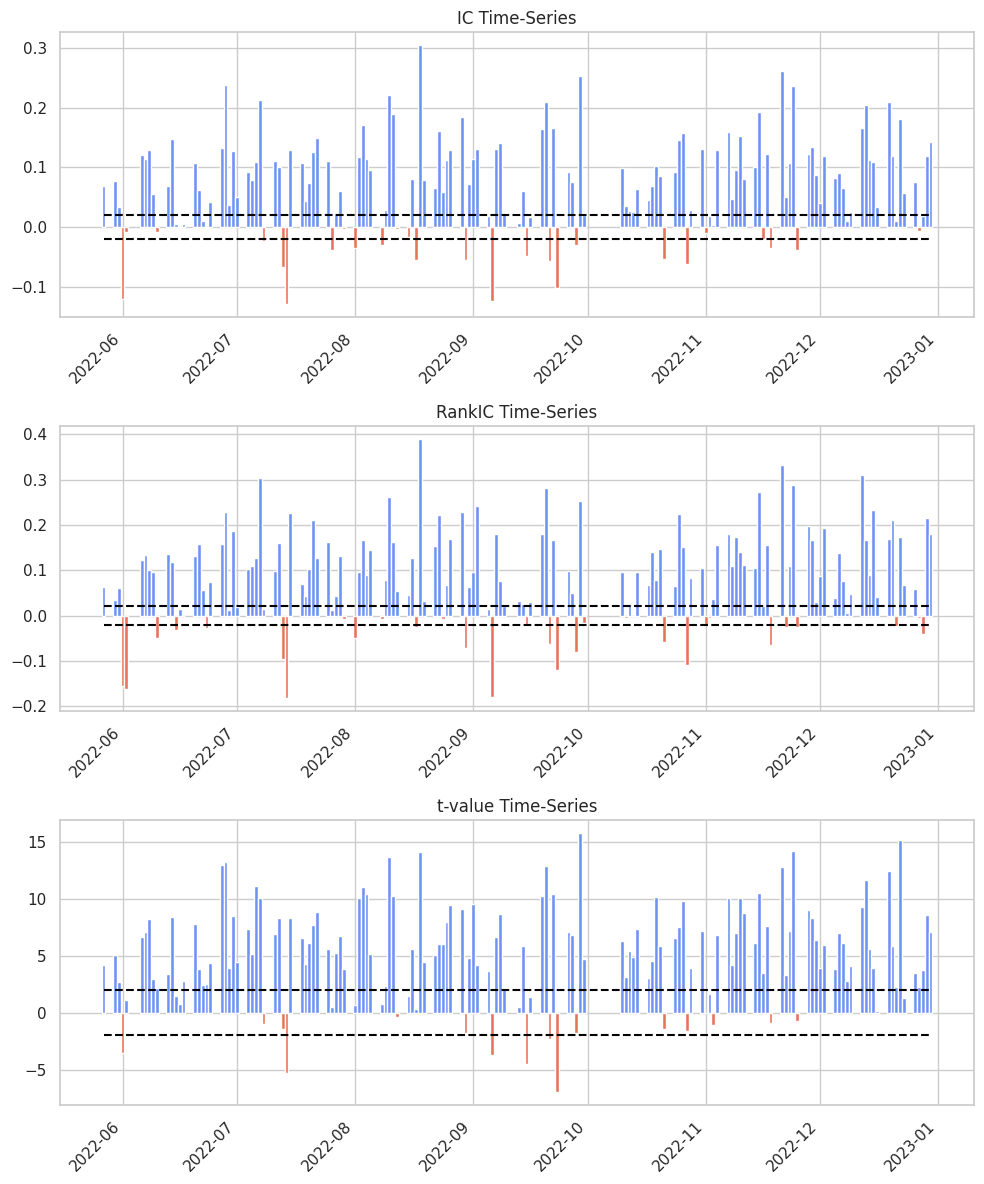

In [ ]:
import matplotlib.dates as mdates

sns.set_theme(style="whitegrid")

positive_color = sns.color_palette("coolwarm", 5)[0]
negative_color = sns.color_palette("coolwarm", 5)[-1]
significant_line_color = 'black'

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# IC Plot
positive_idx = IC >= 0
negative_idx = ~positive_idx
axs[0].bar(backtest_date[positive_idx], IC[positive_idx], color=positive_color, width=1.0)
axs[0].bar(backtest_date[negative_idx], IC[negative_idx], color=negative_color, width=1.0)
axs[0].hlines(0.02, backtest_date.min(), backtest_date.max(), colors=significant_line_color, linestyles='dashed')
axs[0].hlines(-0.02, backtest_date.min(), backtest_date.max(), colors=significant_line_color, linestyles='dashed')
axs[0].set_title('IC Time-Series')
axs[0].xaxis.set_major_locator(mdates.MonthLocator())
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# RankIC Plot
positive_idx = RankIC >= 0
negative_idx = ~positive_idx
axs[1].bar(backtest_date[positive_idx], RankIC[positive_idx], color=positive_color, width=1.0)
axs[1].bar(backtest_date[negative_idx], RankIC[negative_idx], color=negative_color, width=1.0)
axs[1].hlines(0.02, backtest_date.min(), backtest_date.max(), colors=significant_line_color, linestyles='dashed')
axs[1].hlines(-0.02, backtest_date.min(), backtest_date.max(), colors=significant_line_color, linestyles='dashed')
axs[1].set_title('RankIC Time-Series')
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# t_value Plot
positive_idx = t_value >= 0
negative_idx = ~positive_idx
axs[2].bar(backtest_date[positive_idx], t_value[positive_idx], color=positive_color, width=1.0)
axs[2].bar(backtest_date[negative_idx], t_value[negative_idx], color=negative_color, width=1.0)
axs[2].hlines(1.96, backtest_date.min(), backtest_date.max(), colors=significant_line_color, linestyles='dashed')
axs[2].hlines(-1.96, backtest_date.min(), backtest_date.max(), colors=significant_line_color, linestyles='dashed')
axs[2].set_title('t-value Time-Series')
axs[2].xaxis.set_major_locator(mdates.MonthLocator())
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better visibility
for ax in axs:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

### 2. Factor Stock-Selection Backtesting

**🧮 METHODOLOGY**

After neutralizing the factor against industry and capitalization, we divided stocks into five portfolios based on their factor loadings, ranking them from highest to lowest. These portfolios consist of top 20% performers, the next 20%, the middle 20%, the next 20%, and the bottom 20% with equal weight to each stock. We tracked their returns, and compared these returns to the market portfolio's return, represented by an equal-weighted portfolio of all stocks, to calculate excess returns. **If the factor accurately predicts profitability, we expect a descending pattern of performance, from highest profit in the top quintile to losses in the bottom.**

Additionally, we evaluated the factor's effectiveness through three strategies:
- A **long portfolio** investing in the top 20% stocks with equal-weighted long positions,
- A **short portfolio** investing in the in the bottom 20%  with equal-weighted short positions, and
- A **long-short portfolio** combining the two with equal weights.

**📈 RESULTS**

**Quintile Performance: Mean Daily Excess Return**

| Quintile | Mean Daily Excess Return |
|----------|--------------------------|
| Group 1  | 0.1559%                  |
| Group 2  | 0.0554%                  |
| Group 3  | 0.0540%                  |
| Group 4  | 0.0048%                  |
| Group 5  | -0.2697%                 |
```

The results show a clear descending trend in excess returns from the top-performing quintile to the bottom, indicating the factor's effectiveness in predicting stock profitability.

**Portfolio Performance Metrics**

| Portfolio          | Average Daily Return | Annualized Cumulative Return | Annualized Sharpe Ratio | Maximum Drawdown | Hit Rate |
|--------------------|----------------------|------------------------------|-------------------------|------------------|----------|
| LONG PORTFOLIO     | 0.21%                | 68.0%                        | 2.66                    | -93.1%           | 59.1%    |
| SHORT PORTFOLIO    | 0.21%                | 66.9%                        | 2.69                    | -94.1%           | 51.7%    |
| LONG-SHORT PORTFOLIO | 0.21%              | 70.7%                        | 14.48                   | -98.9%           | 84.6%    |
```

The long-short portfolio, combining the best and worst performers based on factor loadings, yielded the highest annualized cumulative return and Sharpe ratio, demonstrating substantial profitability and risk-adjusted performance. The hit rate for this strategy was also notably high, further validating the factor's predictive power.

In [ ]:
# Neutralize the factor exposure to the industry and market capitalization

residuals_list = []

for t in backtest_date:
    data_t = data_test_dl[data_test_dl['Date'] == t]
    X = np.concatenate((data_t[['MktCap']].values, pd.get_dummies(data_t['Industry'], prefix='Industry').values), axis=1)
    y = data_t['DL Factor (Standardized)'].values
    model = sm.OLS(y, sm.add_constant(X)).fit()
    y_pred = model.predict(sm.add_constant(X))
    residuals = y - y_pred
    residuals_list.extend(list(zip(data_t.index, residuals)))

residuals_df = pd.DataFrame(residuals_list, columns=['index', 'DL Factor (Neutralized)'])
residuals_df.set_index('index', inplace=True)
data_test_dl = data_test_dl.join(residuals_df)
del residuals_df

data_test_dl.head()

,Date,Ticker,Tomorrow Ret,Tomorrow Ret (Scaled) (Standardized),DL Factor (Standardized),Industry,MktCap,DL Factor (Neutralized)
0,2022-05-27,000001.SZ,-0.007052,-0.688607,0.229830,002094.CJ,2.751759e+11,0.267324
1,2022-05-27,000002.SZ,-0.017641,-1.167042,0.093312,002118.CJ,2.108845e+11,0.241863
2,2022-05-27,000004.SZ,0.019108,0.493450,0.087833,002112.CJ,1.469549e+09,0.009769
3,2022-05-27,000005.SZ,0.000000,-0.369955,0.631381,002059.CJ,1.968879e+09,0.520765
4,2022-05-27,000006.SZ,-0.004566,-0.576279,-0.519335,002118.CJ,5.912978e+09,-0.474114


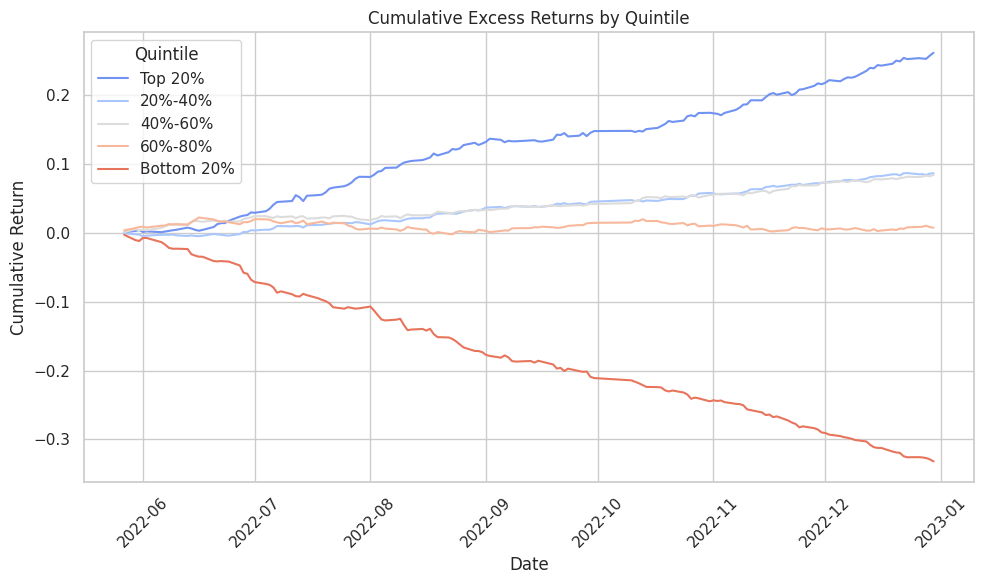

In [ ]:
# Initialize lists to store daily returns for each quintile
daily_return_1, daily_return_2, daily_return_3, daily_return_4, daily_return_5 = [], [], [], [], []
daily_return_mkt = []

for t in backtest_date:
    data_t = data_test_dl[data_test_dl['Date'] == t]
    data_t_sorted = data_t.sort_values('DL Factor (Neutralized)', ascending=False)

    quintile_size = len(data_t_sorted) // 5

    quintiles = {
        1: data_t_sorted.iloc[:quintile_size],
        2: data_t_sorted.iloc[quintile_size:2*quintile_size],
        3: data_t_sorted.iloc[2*quintile_size:3*quintile_size],
        4: data_t_sorted.iloc[3*quintile_size:4*quintile_size],
        5: data_t_sorted.iloc[4*quintile_size:]
    }

    for i in range(1, 6):
        mkt_return = data_t['Tomorrow Ret'].mean()
        mean_return = quintiles[i]['Tomorrow Ret'].mean()
        if i == 1:
            daily_return_1.append(mean_return)
        elif i == 2:
            daily_return_2.append(mean_return)
        elif i == 3:
            daily_return_3.append(mean_return)
        elif i == 4:
            daily_return_4.append(mean_return)
        elif i == 5:
            daily_return_5.append(mean_return)

    daily_return_mkt.append(mkt_return)

daily_return_1 = np.array(daily_return_1)
daily_return_2 = np.array(daily_return_2)
daily_return_3 = np.array(daily_return_3)
daily_return_4 = np.array(daily_return_4)
daily_return_5 = np.array(daily_return_5)
daily_return_mkt = np.array(daily_return_mkt)

cumulative_return_1 = np.cumprod(1 + daily_return_1 - daily_return_mkt) - 1
cumulative_return_2 = np.cumprod(1 + daily_return_2 - daily_return_mkt) - 1
cumulative_return_3 = np.cumprod(1 + daily_return_3 - daily_return_mkt) - 1
cumulative_return_4 = np.cumprod(1 + daily_return_4 - daily_return_mkt) - 1
cumulative_return_5 = np.cumprod(1 + daily_return_5 - daily_return_mkt) - 1

colors = sns.color_palette("coolwarm", 5)
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

plt.plot(backtest_date, cumulative_return_1, label='Top 20%', color=colors[0])
plt.plot(backtest_date, cumulative_return_2, label='20%-40%', color=colors[1])
plt.plot(backtest_date, cumulative_return_3, label='40%-60%', color=colors[2])
plt.plot(backtest_date, cumulative_return_4, label='60%-80%', color=colors[3])
plt.plot(backtest_date, cumulative_return_5, label='Bottom 20%', color=colors[4])

plt.title('Cumulative Excess Returns by Quintile')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Quintile')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print(f"{'Quintile':<15}{'Mean Daily Excess Return':>25}")
print("-" * 40)
print(f"{'Group 1':<30}{(daily_return_1 - daily_return_mkt).mean()*100:>10.4f}%")
print(f"{'Group 2':<30}{(daily_return_2 - daily_return_mkt).mean()*100:>10.4f}%")
print(f"{'Group 3':<30}{(daily_return_3 - daily_return_mkt).mean()*100:>10.4f}%")
print(f"{'Group 4':<30}{(daily_return_4 - daily_return_mkt).mean()*100:>10.4f}%")
print(f"{'Group 5':<30}{(daily_return_5 - daily_return_mkt).mean()*100:>10.4f}%")

Quintile        Mean Daily Excess Return
----------------------------------------
Group 1                           0.1559%
Group 2                           0.0554%
Group 3                           0.0540%
Group 4                           0.0048%
Group 5                          -0.2697%


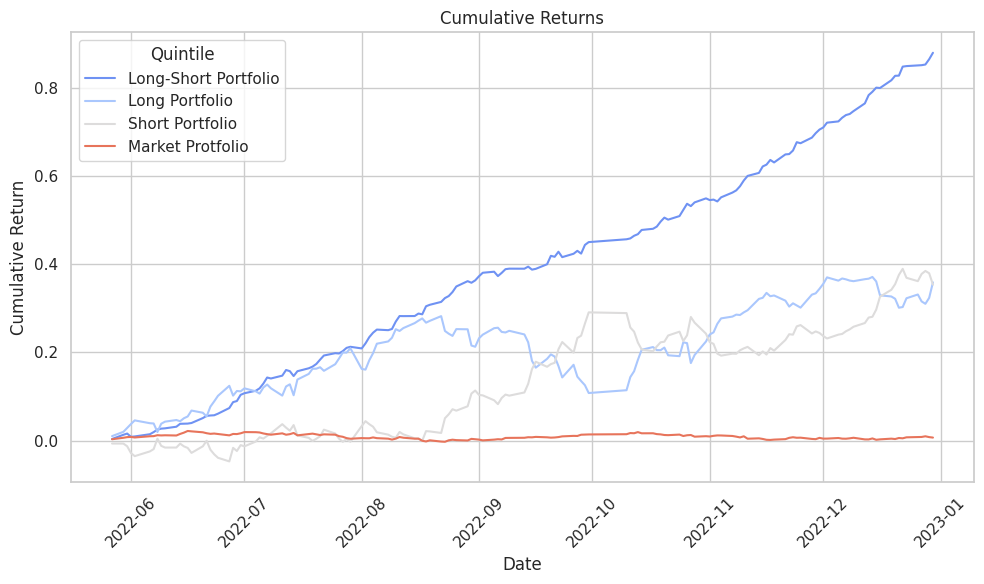

In [ ]:
cumulative_return_long = np.cumprod(1 + daily_return_1) - 1
cumulative_return_short = np.cumprod(1 - daily_return_5) - 1
cumulative_return_long_short = np.cumprod(1 + (daily_return_1 - daily_return_5)) - 1
cumulative_return_mkt = np.cumprod(1 + daily_return_mkt) - 1

colors = sns.color_palette("coolwarm", 5)
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

plt.plot(backtest_date, cumulative_return_long_short, label='Long-Short Portfolio', color=colors[0])
plt.plot(backtest_date, cumulative_return_long, label='Long Portfolio', color=colors[1])
plt.plot(backtest_date, cumulative_return_short, label='Short Portfolio', color=colors[2])
plt.plot(backtest_date, cumulative_return_4, label='Market Protfolio', color=colors[-1])

plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Quintile')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
def calculte_portfolio_performance(daily_return):
    cumulative_return = np.prod(1 + daily_return) - 1
    annualized_cumulative_return = (1 + cumulative_return) ** (252 / len(daily_return)) - 1

    average_daily_return = np.mean(daily_return)
    annualized_sharpe_ratio = (np.mean(daily_return) / np.std(daily_return)) * np.sqrt(252)

    rolling_max = np.maximum.accumulate(daily_return + 1)
    daily_drawdown = (rolling_max - (daily_return + 1)) / rolling_max
    maximum_drawdown = np.max(daily_drawdown) - 1

    hit_rate = np.mean(daily_return > 0)

    return average_daily_return, annualized_cumulative_return, annualized_sharpe_ratio, maximum_drawdown, hit_rate

In [ ]:
print('LONG PORTFOLIO')
average_daily_return, annualized_cumulative_return, annualized_sharpe_ratio, maximum_drawdown, hit_rate = calculte_portfolio_performance(daily_return_1)
print()
print(f"{'Metric':<40}{'Value':>10}")
print("-" * 50)
print(f"{'Average Daily Return':<40}{average_daily_return * 100:>9.2f}%")
print(f"{'Annualized Cumulative Return':<40}{annualized_cumulative_return * 100:>9.1f}%")
print(f"{'Annualized Sharpe Ratio':<40}{annualized_sharpe_ratio:>10.2f}")
print(f"{'Maximum Drawdown':<40}{maximum_drawdown * 100:>9.1f}%")
print(f"{'Hit Rate':<40}{hit_rate * 100:>9.1f}%")

print()
print()
print('SHORT PORTFOLIO')
average_daily_return, annualized_cumulative_return, annualized_sharpe_ratio, maximum_drawdown, hit_rate = calculte_portfolio_performance(- daily_return_5)
print()
print(f"{'Metric':<40}{'Value':>10}")
print("-" * 50)
print(f"{'Average Daily Return':<40}{average_daily_return * 100:>9.2f}%")
print(f"{'Annualized Cumulative Return':<40}{annualized_cumulative_return * 100:>9.1f}%")
print(f"{'Annualized Sharpe Ratio':<40}{annualized_sharpe_ratio:>10.2f}")
print(f"{'Maximum Drawdown':<40}{maximum_drawdown * 100:>9.1f}%")
print(f"{'Hit Rate':<40}{hit_rate * 100:>9.1f}%")

print()
print()
print('LONG-SHORT PORTFOLIO')
average_daily_return, annualized_cumulative_return, annualized_sharpe_ratio, maximum_drawdown, hit_rate = calculte_portfolio_performance((daily_return_1 - daily_return_5))
print()
print(f"{'Metric':<40}{'Value':>10}")
print("-" * 50)
print(f"{'Average Daily Return':<40}{average_daily_return * 100:>9.2f}%")
print(f"{'Annualized Cumulative Return':<40}{annualized_cumulative_return * 100:>9.1f}%")
print(f"{'Annualized Sharpe Ratio':<40}{annualized_sharpe_ratio:>10.2f}")
print(f"{'Maximum Drawdown':<40}{maximum_drawdown * 100:>9.1f}%")
print(f"{'Hit Rate':<40}{hit_rate * 100:>9.1f}%")

LONG PORTFOLIO

Metric                                       Value
--------------------------------------------------
Average Daily Return                         0.21%
Annualized Cumulative Return                 68.0%
Annualized Sharpe Ratio                       2.66
Maximum Drawdown                            -93.1%
Hit Rate                                     59.1%


SHORT PORTFOLIO

Metric                                       Value
--------------------------------------------------
Average Daily Return                         0.21%
Annualized Cumulative Return                 66.9%
Annualized Sharpe Ratio                       2.69
Maximum Drawdown                            -94.1%
Hit Rate                                     51.7%


LONG-SHORT PORTFOLIO

Metric                                       Value
--------------------------------------------------
Average Daily Return                         0.43%
Annualized Cumulative Return                190.8%
Annualized Sharpe Ratio